Jonnatan Arias Garcia

jonnatan.arias@utp.edu.co
jariasg@uniquindio.edu.co

# Convolutional (Espectral) graph

La convolución en graph es esencial, pues se usa como medida base para propagar mensajes (Message passeing es nuestra versión de feedforward de NN) entre los nodos.
por ende generalmente se da por entendido que modelos como los recurrentes o de con attención hacen uso de convoluciones como medida base.

En el actual notebook veremos algunos  modelos base para Convolucion en graph.

1. ChebyNet
2. GCNConv




# Imports y utils

In [113]:
!pip install torch_geometric

In [114]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# La Convolución

## Convolución General

Porque conv.?
* Weight Sharing
* Deteccion de traslaciones invairante y caracteristicas locales

\begin{align*}
c[n] = (v * w)[n] = \sum_{m=0}^{N-1} v[m] \cdot w[n-m]
\end{align*}

In [115]:
def conv(v, w):
    c = np.zeros(v.shape)
    for n in range(len(v)):
        c[n] = 0
        for m in range(len(v)):
            c[n] += v[m] * w[n - m]
    return c

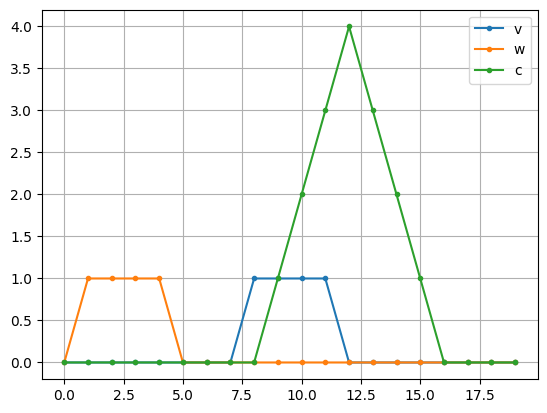

In [116]:
N = 20
v = np.zeros(N)
v[8:12] = 1
w = np.zeros(N)
w[1:5] = 1
c = conv(v, w)

fig = plt.figure()
ax = fig.gca()
ax.plot(v, '.-')
ax.plot(w, '.-')
ax.plot(c, '.-')
ax.legend(['v', 'w', 'c'])
ax.grid(True)

### Trasnformada de Fourier

Transformación $\mathcal F: \mathbb{R}^N \to \mathbb{R}^N$ con

\begin{align*}
\mathcal F^{-1}(\mathcal F (v)) &= v\\
\mathcal F(v * w) &= \mathcal F(v) \cdot \mathcal F(w).
\end{align*}

Esto implica:
\begin{align*}
v * w &= \mathcal F^{-1}(\mathcal F (v * w))\\
&= \mathcal F^{-1}(\mathcal F(v) \cdot \mathcal F(w))
\end{align*}

In [117]:
v, w = np.random.rand(N), np.random.rand(N)
conv(v, w)

array([3.7938573 , 3.80318259, 4.2467523 , 3.86957554, 4.07188761,
       3.7529004 , 4.52770295, 4.17304798, 3.9287955 , 3.48923149,
       4.34790303, 4.23157277, 4.11709847, 3.74879806, 4.66999785,
       4.38693935, 3.9420491 , 4.13854603, 4.05384903, 4.1521277 ])

In [118]:
from scipy.fft import fft, ifft # Fast Fourier Transform / Inverse FFT
np.abs(ifft(fft(v) * fft(w)))

array([3.7938573 , 3.80318259, 4.2467523 , 3.86957554, 4.07188761,
       3.7529004 , 4.52770295, 4.17304798, 3.9287955 , 3.48923149,
       4.34790303, 4.23157277, 4.11709847, 3.74879806, 4.66999785,
       4.38693935, 3.9420491 , 4.13854603, 4.05384903, 4.1521277 ])

### Definición de la transformada de fourier


\begin{align*}
\mathcal F(v) = U\cdot v, \;\;\mathcal F^{-1}(v) = \frac{1}{N}\ U^H \cdot v
\end{align*}

Donde   la matriz $U$ de $N\times N$ es definida como
\begin{align*}
\\
U =
\begin{bmatrix}
u_0(0) & u_1(0) & \dots & u_{N-1}(0)\\
u_0(1) & u_1(1) & \dots & u_{N-1}(1)\\
\vdots & \vdots& & \vdots\\
u_0(N-1) & u_1(N-1) & \dots & u_{N-1}(N-1)\\
\end{bmatrix}
\end{align*}

y $u_0, \dots, u_{N-1}$son funciones definidas como

\begin{align*}
u_n(x)&:= \cos\left(2 \pi \frac{n}{N} x\right) - i \sin\left(2 \pi \frac{n}{N} x\right).
\end{align*}

In [119]:
def matrix_U(N):
    u = lambda n, N: np.cos(2 * np.pi / N * n * np.arange(N)) - 1j * np.sin(2 * np.pi / N * n * np.arange(N))
    U = np.empty((N, 0))
    for n in range(N):
        U = np.c_[U, u(n, N)]
    return U


def fourier_transform(v):
    N = v.shape[0]
    U = matrix_U(N)
    return U @ v


def inverse_fourier_transform(v):
    N = v.shape[0]
    U = matrix_U(N)
    return (U.conj().transpose() @ v) / N

In [120]:
fft(v) - fourier_transform(v)

array([ 0.00000000e+00-0.00000000e+00j,  6.24500451e-16-1.11022302e-16j,
        4.44089210e-16+7.77156117e-16j, -2.77555756e-16+2.44249065e-15j,
        0.00000000e+00+1.11022302e-16j,  4.66293670e-15-1.11022302e-15j,
       -1.88737914e-15-3.05311332e-15j,  1.19348975e-15-7.21644966e-16j,
        7.77156117e-16-4.44089210e-16j,  3.88578059e-16+2.44249065e-15j,
       -1.77635684e-15+6.65436249e-16j, -3.21964677e-15+2.66453526e-15j,
       -6.32827124e-15-4.44089210e-15j, -1.44328993e-15-7.38298311e-15j,
       -2.10942375e-15-8.16013923e-15j,  6.43929354e-15-1.66533454e-15j,
        6.66133815e-16-2.77555756e-16j, -4.44089210e-16-7.60502772e-15j,
        0.00000000e+00+9.93649607e-15j, -8.49320614e-15+3.44169138e-15j])

In [121]:
ifft(v) - inverse_fourier_transform(v)

array([ 1.11022302e-16-0.00000000e+00j,  3.98986399e-17+1.38777878e-17j,
        0.00000000e+00-3.03576608e-17j, -2.25514052e-17-1.17961196e-16j,
        0.00000000e+00-1.04083409e-17j,  2.49800181e-16+6.24500451e-17j,
       -9.71445147e-17+1.56125113e-16j,  5.89805982e-17+4.16333634e-17j,
        6.24500451e-17+2.08166817e-17j,  8.67361738e-18-1.38777878e-16j,
       -2.08166817e-17-3.32718124e-17j, -1.76941795e-16-1.38777878e-16j,
       -3.19189120e-16+2.22044605e-16j, -6.93889390e-17+3.64291930e-16j,
       -1.04083409e-16+4.19803081e-16j,  3.33066907e-16+8.32667268e-17j,
        2.77555756e-17+0.00000000e+00j, -3.29597460e-17+3.62557206e-16j,
        0.00000000e+00-4.91360425e-16j, -4.37150316e-16-1.59594560e-16j])

### Conexión con el Laplaciano

Las funciones $u_n$ (Las columnas de la matriz de transformacion de Fourier) son los eigenvectors del Laplaciano:

\begin{align*}
u_n(x)&:= \cos\left(2 \pi \frac{n}{N} x\right) - i \sin\left(2 \pi \frac{n}{N} x\right)\\
\Delta u_n(x)&:= \left(-4 \pi ^ 2\frac{n^2}{N^2}\right) u_n(x)
\end{align*}

### summary
\begin{align*}
v * w
= U^H ((U  w) \odot (U  v))
\end{align*}

o si $g_w=\mbox{diag}(U w)$ es filtrado
\begin{align*}
v * w
= U^H g_w U  w
\end{align*}

In [122]:
U = matrix_U(N)
np.abs((U.conj().transpose() / N) @ ((U @ v) * (U @ w)))

array([3.7938573 , 3.80318259, 4.2467523 , 3.86957554, 4.07188761,
       3.7529004 , 4.52770295, 4.17304798, 3.9287955 , 3.48923149,
       4.34790303, 4.23157277, 4.11709847, 3.74879806, 4.66999785,
       4.38693935, 3.9420491 , 4.13854603, 4.05384903, 4.1521277 ])

In [123]:
conv(v, w)

array([3.7938573 , 3.80318259, 4.2467523 , 3.86957554, 4.07188761,
       3.7529004 , 4.52770295, 4.17304798, 3.9287955 , 3.48923149,
       4.34790303, 4.23157277, 4.11709847, 3.74879806, 4.66999785,
       4.38693935, 3.9420491 , 4.13854603, 4.05384903, 4.1521277 ])

## Convolución en Graph

**Plan**:

     - Definir el grafo laplaciano.

     - Calcular el espectro.

     - Definir una transformada de Fourier

     - Definir convolución en un gráfico.

**Nota:**
De ahora en adelante, $G = (V, E)$ es un gráfico simple, no dirigido y no ponderado.

### Graph Laplacian

Adjacency matrix
\begin{align*}
A_{ij} = \left\{
    \begin{array}{ll}
    1 &\text{ if } e_{ij}\in E\\
    0 &\text{ if } e_{ij}\notin E
    \end{array}
    \right.
\end{align*}

Degree matrix
\begin{align*}
D_{ij} = \left\{
    \begin{array}{ll}
    \mbox{deg}(v_i) &\text{ if } i=j\\
    0 &\text{ if } i\neq j
    \end{array}
    \right.
\end{align*}

Laplacian
\begin{align*}
L &= D - A.
\end{align*}

Normalized Laplacian
\begin{align*}
L &= I - D^{-1/2} A D^{-1/2}.
\end{align*}

### Graph spectrum, Fourier transform, and convolution

1. Spectral decomposition of the Laplacian:
\begin{align*}
L = U \Lambda U^T\\
\end{align*}


2. Fourier transform: if $v$ is a vector of features on the graph, then
\begin{align*}
\mathcal F (v) = U \cdot v, \;\;\mathcal F^{-1} (v) = U^T \cdot v\\
\end{align*}


3. Convolution with a filter $U \cdot w$
\begin{align*}
v * w = U ((U^T  w) \odot (U^T  v) )
\end{align*}


Or $g_w = \mbox{diag}(U^T w)$ is a filter, then
\begin{align*}
v * w = U g_w U^T  v

# Base de datos (karate Club - Node pred)

Zachary karate club - Dataset

El conjunto de datos del club de karate de Zachary representa las relaciones formadas dentro de un club de karate observadas por Wayne W. Zachary durante la década de 1970.

Es una especie de red social, donde cada nodo representa a un miembro del club y los bordes entre los nodos representan interacciones que ocurrieron fuera del entorno del club.

En este escenario particular, los miembros del club se dividen en cuatro grupos distintos.

Nuestra tarea es asignar el grupo correcto a cada miembro **(clasificación de nodos)**, según el patrón de sus interacciones.

In [124]:
from torch_geometric.datasets import KarateClub

In [125]:
# Import dataset from PyTorch Geometric
dataset = KarateClub()
# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

KarateClub()
------------
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [126]:
# Print first element
print(f'Graph: {dataset[0]}')

Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


x=[34, 34] es la matriz de características del nodo con forma (número de nodos, número de características). En nuestro caso, significa que tenemos 34 nodos (nuestros 34 miembros), cada nodo está asociado a un vector de características tenues de 34.


edge_index=[2, 156] representa la conectividad del gráfico (cómo se conectan los nodos) con la forma (2, número de bordes dirigidos).


y=[34] son las etiquetas de verdad fundamental del nodo. En este problema, cada nodo está asignado a una clase (grupo), por lo que tenemos un valor para cada nodo.


train_mask=[34] es un atributo opcional que indica qué nodos deben usarse para el entrenamiento con una lista de declaraciones Verdaderas o Falsas.

In [127]:
data = dataset[0]

In [128]:
print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [129]:
x = torch.Size([34, 34])
'''Aquí, la matriz de características del nodo x es una matriz de identidad:
no contiene ninguna información relevante sobre los nodos. Podría contener
información como edad, nivel de habilidad, etc., pero este no es el caso en
este conjunto de datos.

Significa que tendremos que clasificar nuestros
nodos simplemente mirando sus conexiones.
'''

'Aquí, la matriz de características del nodo x es una matriz de identidad:\nno contiene ninguna información relevante sobre los nodos. Podría contener\ninformación como edad, nivel de habilidad, etc., pero este no es el caso en\neste conjunto de datos.\n\nSignifica que tendremos que clasificar nuestros\nnodos simplemente mirando sus conexiones.\n'

In [130]:
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

'''Una lista almacena nodo origen, otra el nodo destino (formato coordinat lista ó COO)'''

edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3, 

'Una lista almacena nodo origen, otra el nodo destino (formato coordinat lista ó COO)'

In [131]:
from torch_geometric.utils import to_dense_adj

#adjacency matrix
A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (34, 34)
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [132]:
print(f'y = {data.y.shape}')
print(data.y)

y = torch.Size([34])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


In [133]:
print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

train_mask = torch.Size([34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


Train mask, no muestra que nodos deben usarse para entrenar. (nodos de train)

In [134]:
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


is_directed() te dice si el gráfico está dirigido. Un gráfico dirigido significa que la matriz de adyacencia no es simétrica, es decir, la dirección de los bordes importa en las conexiones entre nodos.

isolated_nodes() comprueba si algunos nodos no están conectados al resto del gráfico. Es probable que estos nodos planteen desafíos en tareas como la clasificación debido a su falta de conexiones.

has_self_loops() indica si al menos un nodo está conectado a sí mismo. Esto es distinto del concepto de bucles: un bucle implica un camino que comienza y termina en el mismo nodo, atravesando otros nodos intermedios.

En el contexto del conjunto de datos del club de karate de Zachary, todas estas propiedades devuelven False. Esto implica que el grafo no está dirigido, no tiene nodos aislados y ninguno de sus nodos está conectado entre sí.

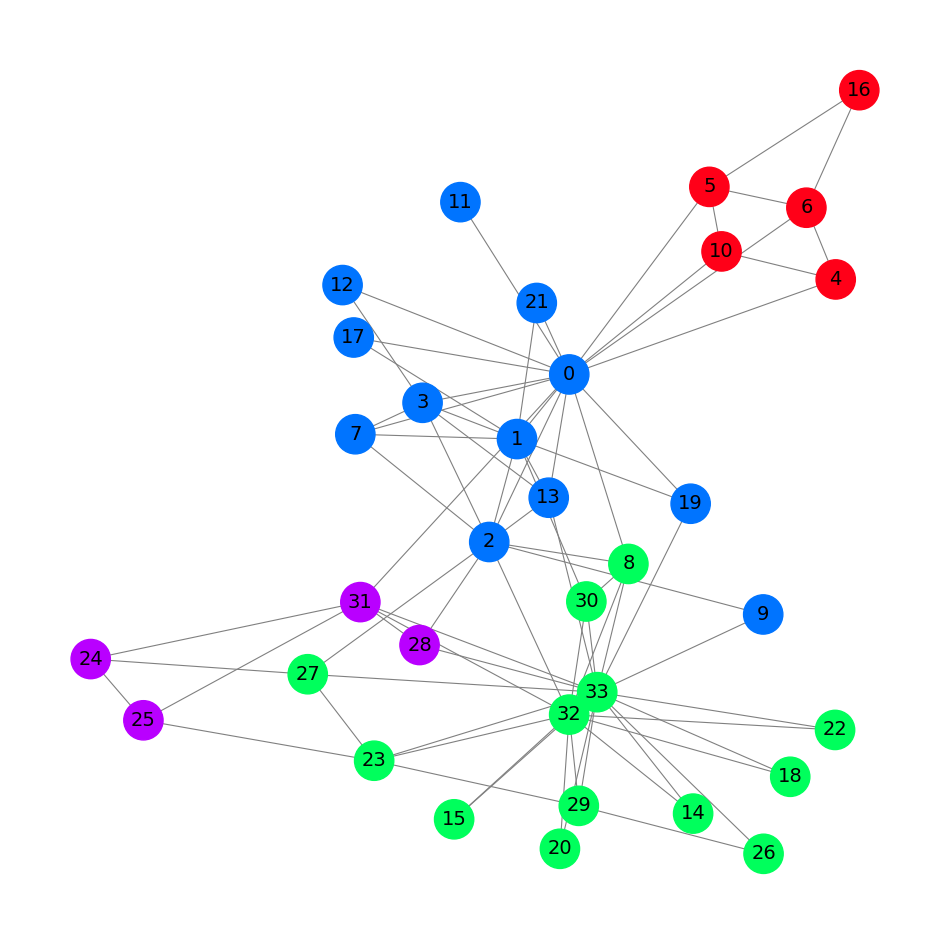

In [135]:
from torch_geometric.utils import to_networkx


#convirtiendo todo a un graph de la libreria networkx
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

#ChebConv

- Original [paper](https://arxiv.org/pdf/1606.09375.pdf)
- PyTorch [doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.ChebConv)

**Objetivo:**
Computar $U g_w U^T x$ Con $g_w = g_w(\Lambda)$ un filtro.

1. Approximación de Chebyshev

Chebyshev polynomials $T_k$:
\begin{align*}
T_{k}(x) = 2 x T_{k-1}(x) - T_{k-2}(x), \;\; T_0(x) = 1, T_1(x) = x
\end{align*}

2. Approximación de Chebyshev  del filter:
\begin{align*}
g_w(\Lambda) = \sum_{k=0}^K \theta_k T_k(\tilde \Lambda),\;\;\;\;\tilde \Lambda = \frac{2}{\lambda_\max} \Lambda - I
\end{align*}


**Propiedad**
If $L = U \Lambda U^T$ then $T_k(L) = U T_k(\Lambda) U^T$.

**Fast approximated convolution**
\begin{align*}
v * w &= U g_w U^T x
= U \left(\sum_{k=0}^K \theta_k T_k(\tilde \Lambda) \right)U^T x
=\sum_{k=0}^K  \theta_k U  T_k(\tilde \Lambda) U^T x\\
&=\sum_{k=0}^K  \theta_k T_k(\tilde L) x
\end{align*}

\begin{align*}
\tilde L = \frac{2}{\lambda_\max} L - I
\end{align*}

Propiedades:
- Depende de $L$ y $\lambda_\max$, no de $U, \Sigma$
- Solo usa $K$-powers $\Rightarrow$ En la vecindad $K$-th de cada nodo. el filtro localizado

In [136]:
from torch_geometric.nn import ChebConv #SAGEConv GCNConv, AGNNConv, SAGEConv,GATConv,GINConv, ChebConv
import torch.nn.functional as F
import torch.nn as nn

In [137]:
class ChebNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, K):
        super(ChebNet, self).__init__()
        self.conv1 = ChebConv(in_channels, hidden_channels, K=K)
        self.conv2 = ChebConv(hidden_channels, out_channels, K=K)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return F.log_softmax(x, dim=1)


In [138]:
# Definir parámetros del modelo
in_channels = dataset.num_features
hidden_channels = 16
out_channels = dataset.num_classes
K = 2  # Orden del polinomio de Chebyshev
# Inicializar el modelo
model = ChebNet(in_channels, hidden_channels, out_channels, K)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)


# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)
# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []



# Entrenamiento del modelo
model.train()
for epoch in range(200):
    optimizer.zero_grad() # Clear gradients

    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask]) # Calculate loss function

    acc = accuracy(out.argmax(dim=1), data.y)# Calculate accuracy

    loss.backward() # Compute gradients
    optimizer.step() # Tune parameters

    # Store data for animations
    embeddings.append(out)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(out.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.4f} | Acc: {acc*100:.2f}%')


Epoch   0 | Loss: 1.3644 | Acc: 29.41%
Epoch  10 | Loss: 0.8258 | Acc: 47.06%
Epoch  20 | Loss: 0.7019 | Acc: 52.94%
Epoch  30 | Loss: 0.6942 | Acc: 55.88%
Epoch  40 | Loss: 0.6935 | Acc: 58.82%
Epoch  50 | Loss: 0.6933 | Acc: 55.88%
Epoch  60 | Loss: 0.6933 | Acc: 55.88%
Epoch  70 | Loss: 0.6933 | Acc: 55.88%
Epoch  80 | Loss: 0.6933 | Acc: 55.88%
Epoch  90 | Loss: 0.6933 | Acc: 55.88%
Epoch 100 | Loss: 0.6932 | Acc: 55.88%
Epoch 110 | Loss: 0.6932 | Acc: 55.88%
Epoch 120 | Loss: 0.6932 | Acc: 55.88%
Epoch 130 | Loss: 0.6932 | Acc: 55.88%
Epoch 140 | Loss: 0.6932 | Acc: 55.88%
Epoch 150 | Loss: 0.6932 | Acc: 55.88%
Epoch 160 | Loss: 0.6932 | Acc: 55.88%
Epoch 170 | Loss: 0.6932 | Acc: 55.88%
Epoch 180 | Loss: 0.6932 | Acc: 55.88%
Epoch 190 | Loss: 0.6932 | Acc: 55.88%


In [139]:
# Evaluación del modelo
model.eval()
_, pred = model(data.x, data.edge_index).max(dim=1)
correct = pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
acc = correct / data.train_mask.sum().item()
print(f'Test Accuracy: {acc}')

Test Accuracy: 0.75


In [140]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

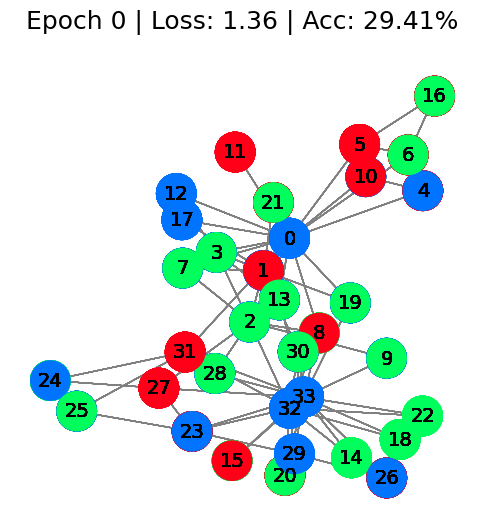

In [141]:
def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)
fig = plt.figure(figsize=(6, 6))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

In [142]:
# Print embeddings
print(f'Final embeddings = {out.shape}')
print(out)

Final embeddings = torch.Size([34, 4])
tensor([[-1.2023e+01, -3.0279e-05, -1.2023e+01, -1.0905e+01],
        [-6.5265e+00, -4.4020e-03, -6.5265e+00, -6.5265e+00],
        [-3.6091e+00, -2.5370e-01, -3.6091e+00, -1.7724e+00],
        [-5.6218e+00, -1.1919e-02, -5.6218e+00, -5.3791e+00],
        [-9.7322e+00, -9.7322e+00, -9.7322e+00, -1.7808e-04],
        [-7.5665e+00, -7.5665e+00, -7.5665e+00, -1.5538e-03],
        [-2.1975e+00, -1.2676e+00, -2.1975e+00, -7.0052e-01],
        [-2.9036e+00, -1.7970e-01, -2.9036e+00, -2.9036e+00],
        [-1.3863e+00, -1.3863e+00, -1.3863e+00, -1.3863e+00],
        [-1.5072e+00, -1.0923e+00, -1.5072e+00, -1.5072e+00],
        [-1.8970e+00, -1.0411e+00, -1.8970e+00, -1.0588e+00],
        [-2.3442e+00, -2.3442e+00, -2.3442e+00, -3.3934e-01],
        [-2.0167e+00, -6.0907e-01, -2.0167e+00, -1.6610e+00],
        [-3.1615e+00, -1.3592e-01, -3.1615e+00, -3.1615e+00],
        [-1.3863e+00, -1.3863e+00, -1.3863e+00, -1.3863e+00],
        [-1.3863e+00, -1.3863e+

In [143]:
# Get first embedding at epoch = 0
embed = out.detach().cpu().numpy()

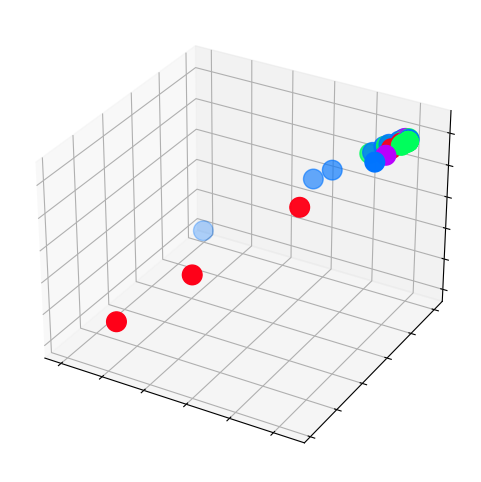

In [144]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
plt.show()

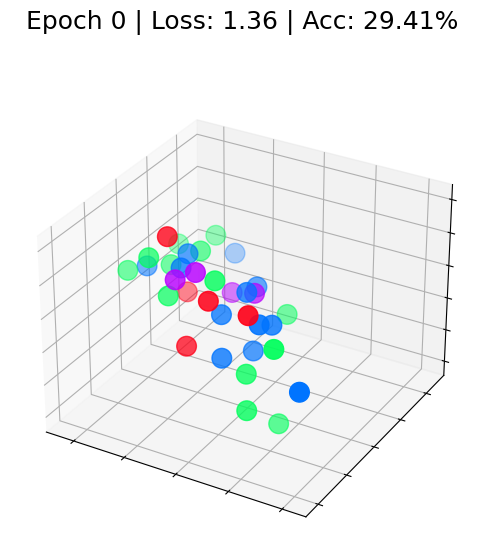

In [145]:
def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)
fig = plt.figure(figsize=(6, 6))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

# GCNConv

- Original [paper](https://arxiv.org/pdf/1609.02907.pdf)
- PyTorch [doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)

Start from `ChebConv` and assume
1. $K=1$ (linear approximation) so
\begin{align*}
v * w
&=\sum_{k=0}^1  \theta_k T_k(\tilde L) x
= \theta_0 x + \theta_1 \tilde L x\\
\end{align*}

2. $\lambda_\max =2$ asi
\begin{align*}
v * w
&= \theta_0 x + \theta_1 (L - I) x\\
&= \theta_0 x - \theta_1 D^{-1/2} A D^{1/2} x\\
\end{align*}


3. $\theta_0=-\theta_1= \theta$ asi
\begin{align*}
v * w = \left(I + D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}

4. Renormalization of $\theta$ by using
\begin{align*}
\tilde A&:= I + A\\
\tilde D_{ii}&:= \sum_j \tilde A_{ij}
\end{align*}
so
\begin{align*}
v * w = \left(D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}

If $x$ is a $F$-dimensional feature vector, and we want an $F'$-dimensional feature vector as output:
use $W'\in \mathbb{R}^{F\times F'}$
\begin{align*}
v * w = \left(D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}


Nodewise:
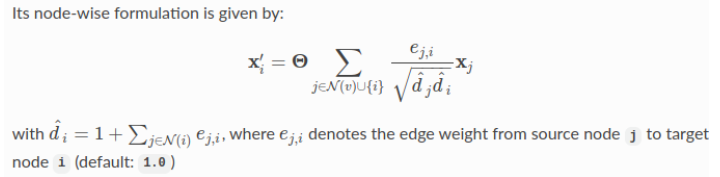

In [146]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [147]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z
model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [148]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [149]:
# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)
# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []
# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()
    # Forward pass
    h, z = model(data.x, data.edge_index)
    # Calculate loss function
    loss = criterion(z, data.y)
    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)
    # Compute gradients
    loss.backward()
    # Tune parameters
    optimizer.step()
    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.36 | Acc: 38.24%
Epoch  10 | Loss: 1.15 | Acc: 38.24%
Epoch  20 | Loss: 0.94 | Acc: 61.76%
Epoch  30 | Loss: 0.77 | Acc: 70.59%
Epoch  40 | Loss: 0.63 | Acc: 85.29%
Epoch  50 | Loss: 0.52 | Acc: 85.29%
Epoch  60 | Loss: 0.46 | Acc: 85.29%
Epoch  70 | Loss: 0.41 | Acc: 85.29%
Epoch  80 | Loss: 0.39 | Acc: 85.29%
Epoch  90 | Loss: 0.37 | Acc: 85.29%
Epoch 100 | Loss: 0.35 | Acc: 85.29%
Epoch 110 | Loss: 0.32 | Acc: 85.29%
Epoch 120 | Loss: 0.27 | Acc: 100.00%
Epoch 130 | Loss: 0.21 | Acc: 100.00%
Epoch 140 | Loss: 0.15 | Acc: 100.00%
Epoch 150 | Loss: 0.11 | Acc: 100.00%
Epoch 160 | Loss: 0.08 | Acc: 100.00%
Epoch 170 | Loss: 0.06 | Acc: 100.00%
Epoch 180 | Loss: 0.04 | Acc: 100.00%
Epoch 190 | Loss: 0.03 | Acc: 100.00%
Epoch 200 | Loss: 0.03 | Acc: 100.00%


In [150]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

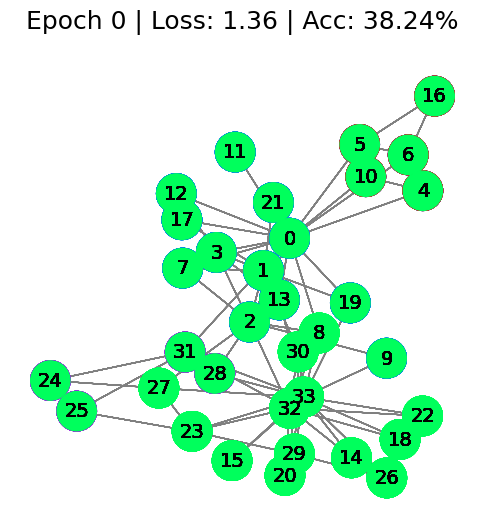

In [151]:
def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)
fig = plt.figure(figsize=(6, 6))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

In [152]:
# Get first embedding at epoch = 0
embed = h.detach().cpu().numpy()

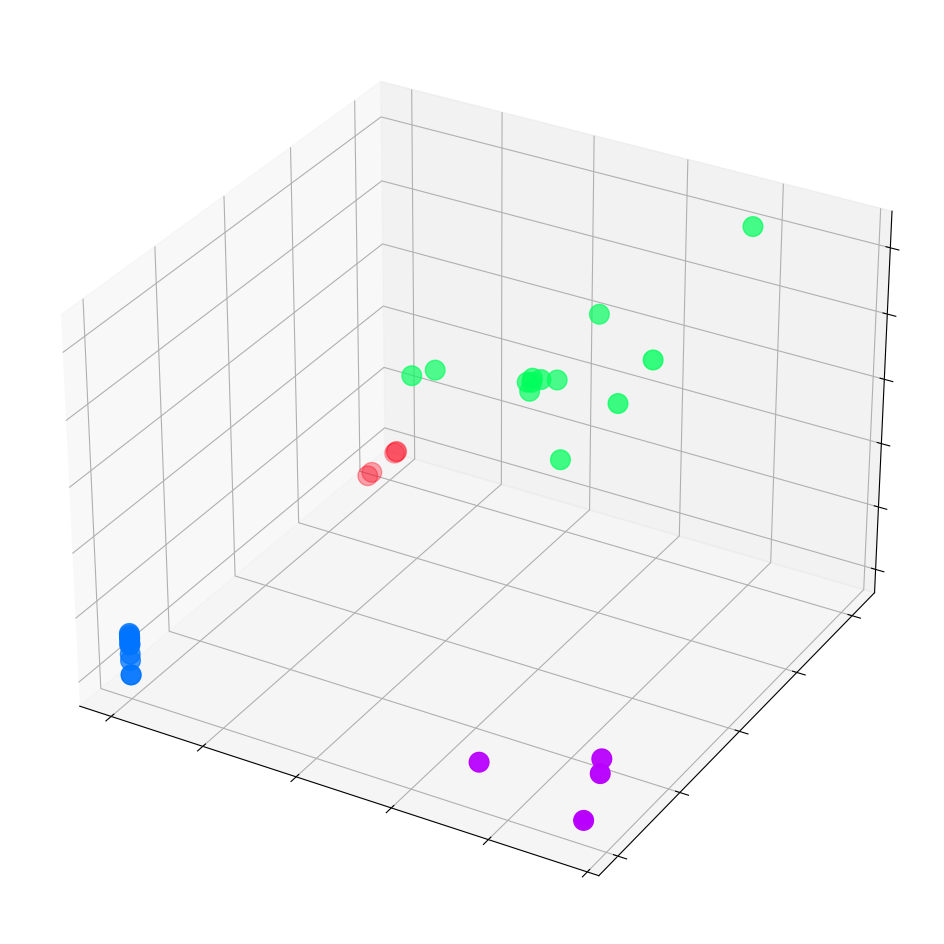

In [153]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
plt.show()

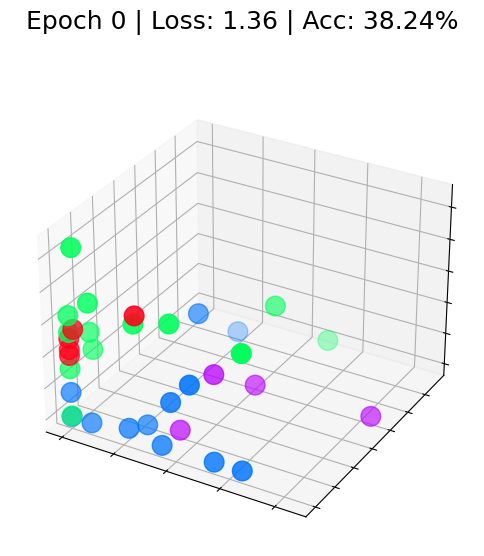

In [154]:
def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)
fig = plt.figure(figsize=(6, 6))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())
display(html)